In [1]:
from torchvision import transforms, datasets
import os
import glob
from random import shuffle
import torch
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
import scipy.io as scio
import numpy as np
import pandas as pd
from resnext import *
import load_data
from torch.autograd import Variable
import time
import random

/home/wangyh/miniconda3/envs/patho_AI/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_info(show_OI = False,show_values = False,**kws):
    length = 'no length'
    keys = 'not a dict'
    values = 'not a dict'
    shape = 'not a ndarray'
    size = 'not a ndarray'
    for key,x in kws.items():
        if hasattr(x,'__len__'):
            length = len(x)
        if isinstance(x,dict):
            keys = x.keys()
            values = x.values()
        if type(x) is np.ndarray or type(x) is cp.ndarray or type(x) is torch.Tensor:
            shape = x.shape
            size = x.size
        print(key)
#         print(f'allocated memory:{binary_conversion(x)}')
        print(f'\ntype:{type(x)} \nlen:{length}\nshape:{shape}\nsize:{size}\nkeys:{keys}\n')
        if show_OI:
            print(f'original info:{x}\n')
        if show_values:
            print(f'\nvalues:{values}\n')

In [2]:
test = np.load('../../config/data_segmentation_csv/10X_grouping.npy',allow_pickle=True).item()
batch_sz = 8
trans_test = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_set = load_data.myDataSet(test['test_list'],data_transforms= trans_test)
dataloader = torch.utils.data.DataLoader(test_set,
                                        batch_size=batch_sz,
                                        shuffle=True,
                                        num_workers=2)
# high TMB为0，low TMB为1
# test_set包含959 H，4697 L

# 加载模型

In [ ]:
random.seed(10)
model = resnext50(num_classes = 2)
checkpoint = torch.load('output/10/epoch_99.pth.tar')
base_dict = {'.'.join(k.split('.')[1:]): v for k, v in list(checkpoint.state_dict().items())}
model.load_state_dict(base_dict)
model_for_eval = torch.nn.Sequential(model,torch.nn.Softmax(dim=1))
model_for_eval.eval()

# 对训练过程可视化

In [4]:
loss = np.load("./output/10/lossdata.npy",allow_pickle= True).item()
acc = np.load('./output/10/accdata.npy',allow_pickle=True).item()

df_loss = pd.DataFrame(loss)

for x in ['train','val']:
    acc[x] = [i.cpu() for i in acc[x]]
df_acc = pd.DataFrame(acc)

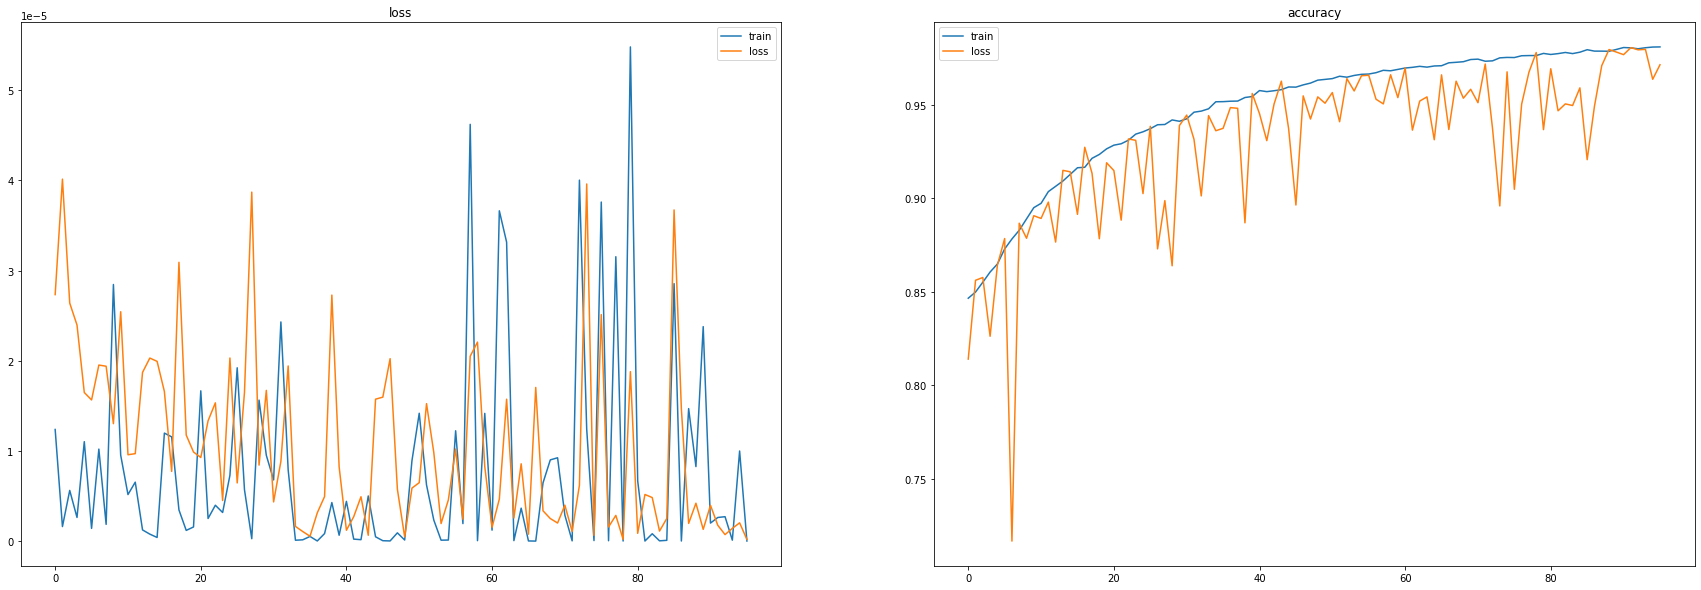

In [6]:
fig,axes = plt.subplots(1,2,figsize = (30,10))
ax1 = axes[0]
ax1.set_title('loss')
ax1.plot(df_loss['train'],label = 'train')
ax1.plot(df_loss['val'],label = 'loss')
ax1.legend()


ax2 = axes[1]
ax2.set_title('accuracy')
ax2.plot(df_acc['train'],label = 'train')
ax2.plot(df_acc['val'],label = 'loss')
ax2.legend()

# 验证testing set

In [6]:
corrects = 0
relabels = torch.tensor([])
predicts = torch.tensor([])
out = torch.tensor([])
lossdata = []
accdata = []

relabels = relabels.cuda()
predicts = predicts.cuda()
out = out.cuda()

criterion = torch.nn.CrossEntropyLoss()

#------------------------------train
start = time.time()
for i, (inputs, labels) in enumerate(dataloader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    model_for_eval = model_for_eval.cuda()
    
    outputs = model_for_eval(inputs)
    _, preds = torch.max(outputs.data, 1)
    
    out = torch.cat((out,_),dim=0)
    loss = criterion(outputs, labels)
    
#-----------------------------statistics
    relabels = torch.cat((relabels,labels),dim=0)
    predicts = torch.cat((predicts,preds),dim=0)
    corrects += torch.sum(preds == labels.data)
    epoch_loss = loss.item() / batch_sz
    epoch_acc = corrects / batch_sz
    
    lossdata.append(epoch_loss)
    accdata.append(epoch_acc)

#-----------------------------evaluation
tp = torch.sum((predicts == 1) * (relabels == 1))  # labeled as TMB_L , and predicted as TMB_L. actually should be assigned as true L(tl),the following are as the same
tn = torch.sum((predicts == 0) * (relabels == 0))
fp = torch.sum((predicts == 1) * (relabels == 0))
fn = torch.sum((predicts == 0) * (relabels == 1))
end = time.time()
print(f'consuming {end-start}s')

consuming 278.6174302101135s


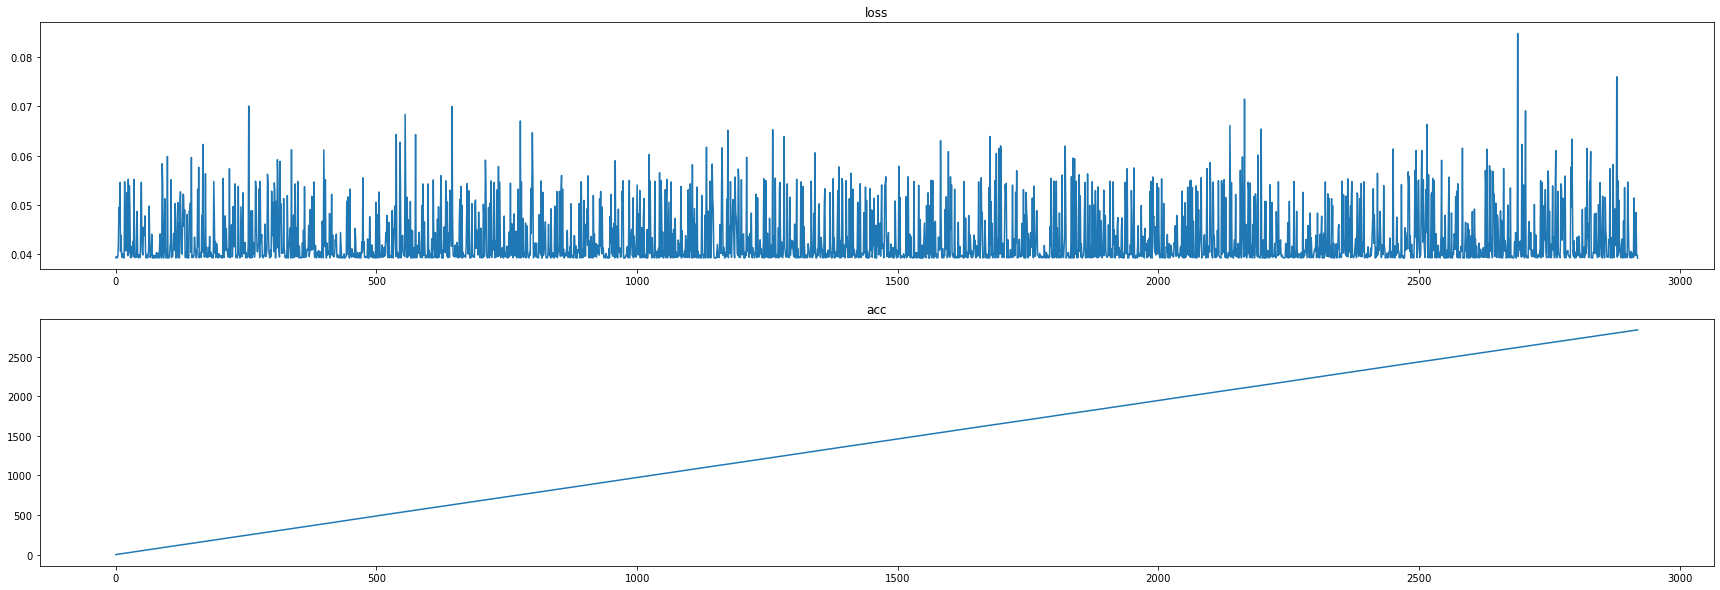

In [7]:
df = pd.DataFrame((lossdata,accdata)).T
df.columns = ['loss','acc']
fig,axes = plt.subplots(2,1,figsize = (30,10))
ax1 = axes[0]
ax1.set_title('loss')
ax1.plot(df['loss'],label = 'loss')

ax2 = axes[1]
ax2.set_title('acc')
ax2.plot(df['acc'],label = 'acc')

In [8]:
print(tp,tn,fp,fn)

tensor(19262, device='cuda:0') tensor(3441, device='cuda:0') tensor(359, device='cuda:0') tensor(291, device='cuda:0')


In [9]:
from sklearn import metrics
relabels = relabels.cpu()
predicts = predicts.cpu()
fpr, tpr, thresholds  =  metrics.roc_curve(relabels, out.cpu()) 
roc_auc = metrics.auc(fpr,tpr)
precision,recall,thr = metrics.precision_recall_curve(relabels,out.cpu())

In [10]:
cm = metrics.confusion_matrix(y_true=relabels,y_pred=predicts)
print(cm)

[[ 3441   359]
 [  291 19262]]


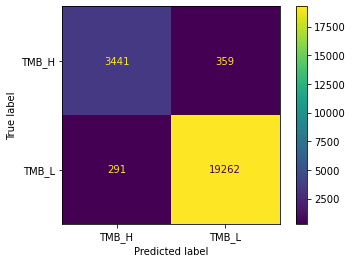

In [11]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=('TMB_H','TMB_L'))
disp.plot()
plt.show()

In [12]:
F1 = metrics.f1_score(y_true=relabels,y_pred=predicts)
F1

0.9834073620258336

In [15]:
print(f'precision = {precision},recall = {recall}')

precision = [0.83728001 0.83727304 0.83730889 ... 0.93797441 0.94565503 1.        ],recall = [1.         0.99994886 0.99994886 ... 0.22119368 0.18421726 0.        ]


<Figure size 432x288 with 0 Axes>

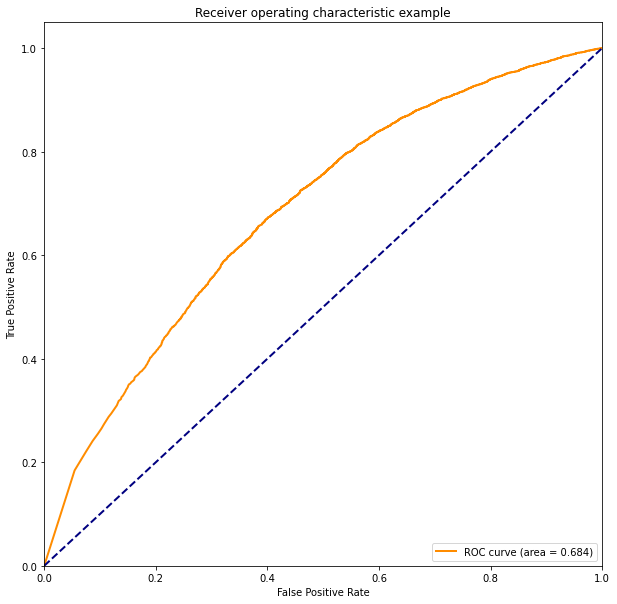

In [13]:
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()

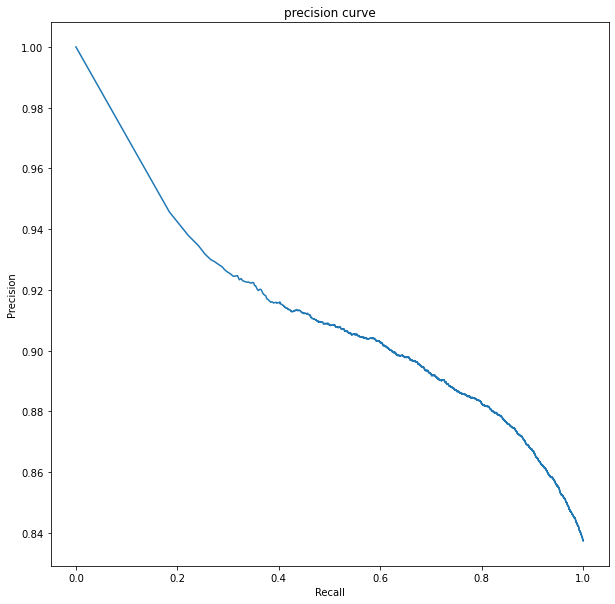

In [14]:
plt.figure(figsize=(10,10))
plt.plot(recall, precision)
plt.title('precision curve')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# 对一个batch进行检验

In [55]:
seq, labels_1 = next(iter(dataloader))
output_1 = model(seq.cuda())

In [56]:
n,preds_1 = torch.max(output_1,dim=1)

In [57]:
print(output_1)

tensor([[ 0.0557, -0.0224],
        [-1.1836,  1.2617],
        [-1.8094,  1.9562],
        [ 0.5285, -0.5270],
        [-0.6384,  0.7252],
        [-1.2161,  1.2595],
        [-2.2050,  2.4941],
        [-2.0150,  2.1112]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [58]:
n

tensor([0.0557, 1.2617, 1.9562, 0.5285, 0.7252, 1.2595, 2.4941, 2.1112],
       device='cuda:0', grad_fn=<MaxBackward0>)

In [59]:
preds_1

tensor([0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')

In [60]:
labels_1

tensor([1, 1, 1, 0, 1, 1, 1, 1])

In [81]:
model_for_eval(seq.cuda())

tensor([[0.5195, 0.4805],
        [0.0798, 0.9202],
        [0.0226, 0.9774],
        [0.7418, 0.2582],
        [0.2037, 0.7963],
        [0.0776, 0.9224],
        [0.0090, 0.9910],
        [0.0159, 0.9841]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [5]:
import os
os.path.join('out',str(5))

'out/5'